# Stock Price Prediction with LSTM-RNN (ANTM-IDX Case)

In this notebook I try to analyze and predict ANTM stock price using deep learning algorithm LSTM-RNN. 
The data is fetched from Tradingview via tvdatafeed API with daily interval. Data start from January 2018 until August 2022.

The selection of data ranges is based on the occurrence of the covid-19 crisis, so I took data before the crisis, during the crisis, and after the crisis occurred.

Training data is carried out from January 2018 to July 2022 then predict future price for August 2022 (also compare it with actual data).

> **_NOTE:_**  
Price predictions from all machine learning cannot guarantee prices will follow their predictions, but with this prediction it can be a reference for traders to be able to make better decisions

Reference: 
- [TvDataFeed](https://github.com/StreamAlpha/tvdatafeed)
- [Stock Price Prediction by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/#h2_12)

## Import Libraries and initialize TvDataFeed

In [50]:
import pandas as pd
import numpy as np
import requests
from termcolor import colored as cl
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [51]:
%%capture
!pip install tvdatafeed
from tvDatafeed import TvDatafeed,Interval

In [52]:
import logging
logging.basicConfig(level=logging.DEBUG)
tv = TvDatafeed()

## Fetch and Visualize Data

In [124]:
df = tv.get_hist(symbol='ANTM',exchange='IDX',interval=Interval.in_daily,n_bars=1120)
df.head()

,symbol,open,high,low,close,volume
datetime,,,,,,
2018-01-03 02:00:00,IDX:ANTM,635.0,655.0,630.0,630.0,43607600.0
2018-01-04 02:00:00,IDX:ANTM,635.0,645.0,635.0,640.0,15064900.0
2018-01-05 02:00:00,IDX:ANTM,645.0,660.0,645.0,655.0,49323700.0
2018-01-08 02:00:00,IDX:ANTM,660.0,660.0,640.0,650.0,31920500.0
2018-01-09 02:00:00,IDX:ANTM,655.0,680.0,650.0,655.0,51688900.0


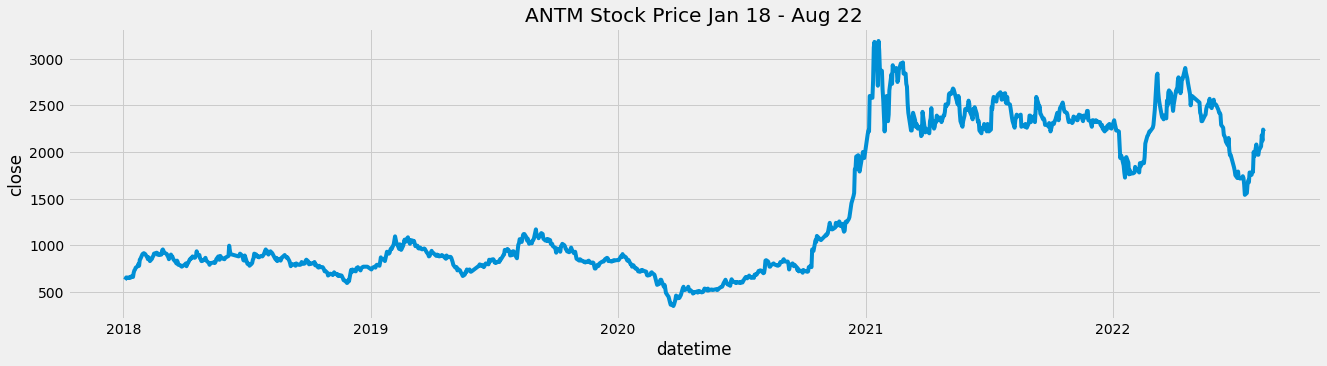

In [125]:
plt.figure(figsize=(20,5))
sns.lineplot(x = "datetime", y = "close", data=df).set_title('ANTM Stock Price Jan 18 - Aug 22')
plt.show()

## A little Exploratory Data Analysis to understand the data more deeply

In [126]:
df.describe()

,open,high,low,close,volume
count,1120.000000,1120.000000,1120.000000,1120.000000,1.120000e+03
mean,1370.476786,1399.566071,1341.827679,1367.862500,1.555586e+08
std,760.991057,779.054002,743.751578,760.180633,2.270442e+08
min,348.000000,364.000000,338.000000,348.000000,8.977100e+06
25%,795.000000,805.000000,780.000000,790.000000,5.084088e+07
50%,925.000000,945.000000,910.000000,925.000000,8.522240e+07
75%,2270.000000,2310.000000,2232.500000,2260.000000,1.531471e+08
max,3300.000000,3440.000000,3060.000000,3190.000000,2.186653e+09


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1120 entries, 2018-01-03 02:00:00 to 2022-08-12 02:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1120 non-null   object 
 1   open    1120 non-null   float64
 2   high    1120 non-null   float64
 3   low     1120 non-null   float64
 4   close   1120 non-null   float64
 5   volume  1120 non-null   float64
dtypes: float64(5), object(1)
memory usage: 61.2+ KB


There is no null value in the data so there is no need data cleaning at all

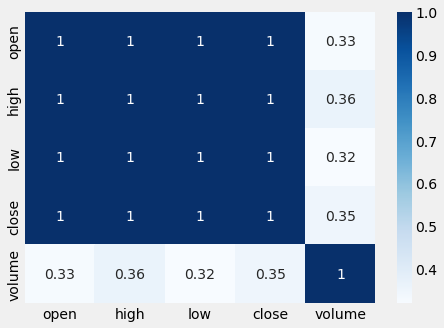

In [128]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),cmap='Blues',annot=True)

From the above heatmap, we can see a large number of 1 and values close to 1. This means those variables show high positive correlations and are interrelated. This might be possible because of the comparatively very small difference between those values. However, in-stock market this small value is what makes the difference. So, what we are going to do, is add new variables to our dataset that represents the difference between those values.

In [129]:
df['open-high'] = df['open']-df['high']
df['open-low'] = df['open'] - df['low']
df['close-high'] = df['close']-df['high']
df['close-low'] = df['close'] - df['low']
df['high-low'] = df['high'] - df['low']
df['open-close'] = df['open'] - df['close']
df.head()

,symbol,open,high,low,close,volume,open-high,open-low,close-high,close-low,high-low,open-close
datetime,,,,,,,,,,,,
2018-01-03 02:00:00,IDX:ANTM,635.0,655.0,630.0,630.0,43607600.0,-20.0,5.0,-25.0,0.0,25.0,5.0
2018-01-04 02:00:00,IDX:ANTM,635.0,645.0,635.0,640.0,15064900.0,-10.0,0.0,-5.0,5.0,10.0,-5.0
2018-01-05 02:00:00,IDX:ANTM,645.0,660.0,645.0,655.0,49323700.0,-15.0,0.0,-5.0,10.0,15.0,-10.0
2018-01-08 02:00:00,IDX:ANTM,660.0,660.0,640.0,650.0,31920500.0,0.0,20.0,-10.0,10.0,20.0,10.0
2018-01-09 02:00:00,IDX:ANTM,655.0,680.0,650.0,655.0,51688900.0,-25.0,5.0,-25.0,5.0,30.0,0.0


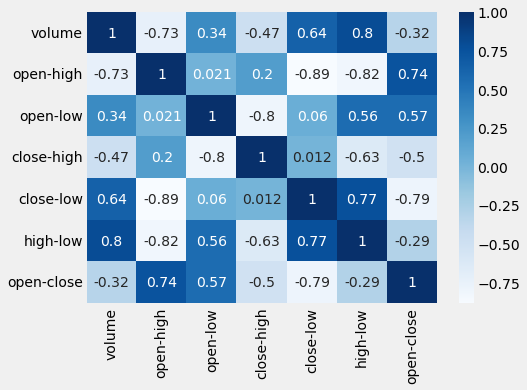

In [130]:
plt.figure(figsize=(7,5))
sns.heatmap(df[['volume','open-high','open-low','close-high','close-low','high-low','open-close']].corr(),cmap='Blues',annot=True)

With this technique we have more useful information instead of just OHLC data.

## BUILD LSTM MODEL 

In [131]:
df = df[['close','volume','open-high','open-low','close-high','close-low','high-low','open-close']]
df.head()

# use below frame for undiffrentiate data, but best practice is using diffrentiate above
# df = df[['close','volume','open','high','low']]
# df.head()

,close,volume,open-high,open-low,close-high,close-low,high-low,open-close
datetime,,,,,,,,
2018-01-03 02:00:00,630.0,43607600.0,-20.0,5.0,-25.0,0.0,25.0,5.0
2018-01-04 02:00:00,640.0,15064900.0,-10.0,0.0,-5.0,5.0,10.0,-5.0
2018-01-05 02:00:00,655.0,49323700.0,-15.0,0.0,-5.0,10.0,15.0,-10.0
2018-01-08 02:00:00,650.0,31920500.0,0.0,20.0,-10.0,10.0,20.0,10.0
2018-01-09 02:00:00,655.0,51688900.0,-25.0,5.0,-25.0,5.0,30.0,0.0


In [132]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [133]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.099226,0.015903,0.969697,0.019231,0.924242,0.000000,0.034431,0.744318,0.102745
2,0.102745,0.002796,0.984848,0.000000,0.984848,0.007576,0.011976,0.732955,0.108023
3,0.108023,0.018527,0.977273,0.000000,0.984848,0.015152,0.019461,0.727273,0.106263
4,0.106263,0.010536,1.000000,0.076923,0.969697,0.015152,0.026946,0.750000,0.108023
5,0.108023,0.019613,0.962121,0.019231,0.924242,0.007576,0.041916,0.738636,0.106263


In [134]:
values = reframed.values
n_train_time = len(reframed)-100

train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/50
15/15 - 3s - loss: 0.0868 - val_loss: 0.1831 - 3s/epoch - 178ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0463 - val_loss: 0.0933 - 93ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0495 - val_loss: 0.0732 - 77ms/epoch - 5ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0471 - val_loss: 0.0719 - 86ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0424 - val_loss: 0.0696 - 83ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0373 - val_loss: 0.0625 - 80ms/epoch - 5ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0331 - val_loss: 0.0542 - 79ms/epoch - 5ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0292 - val_loss: 0.0471 - 84ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0252 - val_loss: 0.0407 - 80ms/epoch - 5ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0221 - val_loss: 0.0346 - 84ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0194 - val_loss: 0.0289 - 87ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0164 - val_loss: 0.0241 - 86ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0141

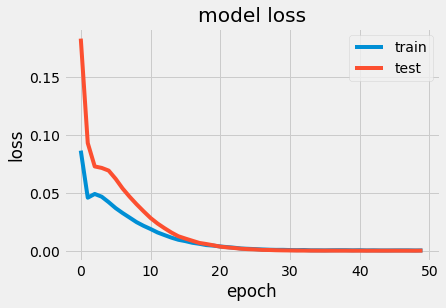

In [135]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [136]:
size = df.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 78.122


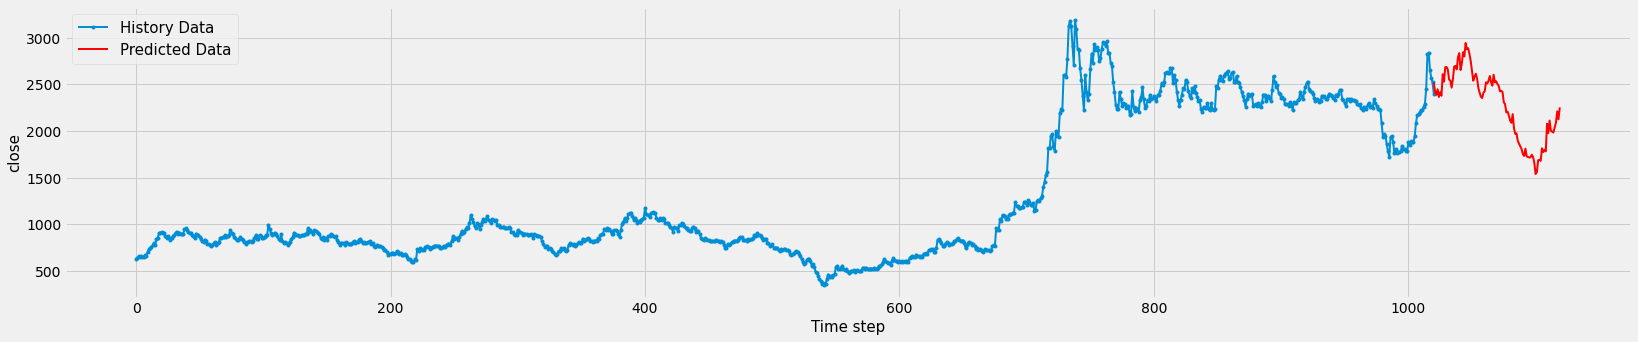

In [137]:
aa=[x for x in range(1120-100,1120)]
bb=[x for x in range(1121-100)]
plt.figure(figsize=(25,5))

plt.plot(bb, df['close'][:1121-100].to_numpy(), marker='.', label="History Data",linewidth=2)
plt.plot(aa, inv_yhat[:100], 'r', label="Predicted Data",linewidth=2)
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

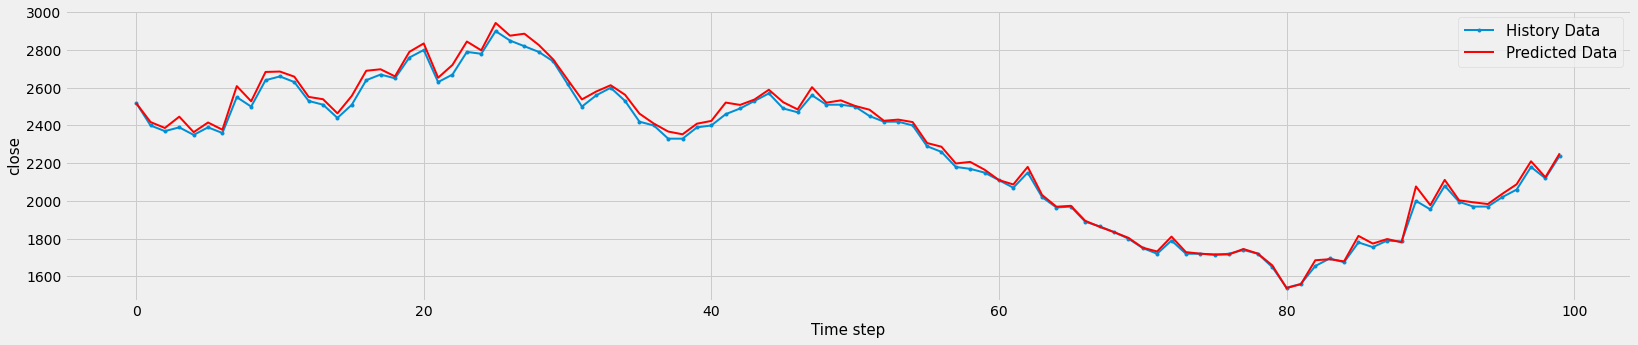

In [138]:
aa=[x for x in range(0,100)]
plt.figure(figsize=(25,5))

plt.plot(aa, df['close'][1119-100:1119].to_numpy(), marker='.', label="History Data",linewidth=2)
plt.plot(aa, inv_yhat[0:100], 'r', label="Predicted Data",linewidth=2)
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

It seems the model is predicted amazing result. So next time I will doing some experiment with other algorithm like traditional ARIMA and also modern RNN like GRU to compare the result with this LSTM. 